In [75]:
import pandas as pd
import re
import string
import spacy
from tqdm import tqdm

tqdm.pandas()
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

NOISE_PATTERNS = [
    r"\b(subscriber only|login to read more|read more|click here|watch video|exclusive|breaking|viral|fact[- ]?check|fake alert|false claim|truth behind|know the truth|explained|must read)\b",
    r"http\S+|www\S+|https\S+",
    r"[^a-zA-Z\s]",
]

def clean_text_spacy(text):
    text = str(text).lower()
    for pattern in NOISE_PATTERNS:
        text = re.sub(pattern, "", text)

    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()

    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

def encode_label(label):
    return 0 if label.lower() == "real" else 1

splits = ["train", "val", "test"]

for split in splits:
    df = pd.read_csv(f"data/{split}_dataset.csv")
    df["clean_headline"] = df["headline"].progress_apply(clean_text_spacy)
    df["label_encoded"] = df["label"].map(encode_label)
    df = df[["clean_headline", "label", "label_encoded", "category", "source"]]
    df.to_csv(f"data/processed_{split}.csv", index=False)
    print(f"✅ Cleaned and saved: data/processed_{split}.csv")

100%|█████████████████████████████████████████| 43163/43163 [01:09<00:00, 617.80it/s]


✅ Cleaned and saved: data/processed_train.csv


100%|███████████████████████████████████████████| 5395/5395 [00:08<00:00, 669.65it/s]


✅ Cleaned and saved: data/processed_val.csv


100%|███████████████████████████████████████████| 5396/5396 [00:08<00:00, 638.17it/s]

✅ Cleaned and saved: data/processed_test.csv


In [33]:
# Load datasets
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

# Optional: remove headlines that are too short
min_len = 5
train_df = train_df[train_df["clean_headline"].str.len() > min_len]
val_df = val_df[val_df["clean_headline"].str.len() > min_len]
test_df = test_df[test_df["clean_headline"].str.len() > min_len]

X_train, y_train = train_df["clean_headline"], train_df["label_encoded"]
X_val, y_val = val_df["clean_headline"], val_df["label_encoded"]
X_test, y_test = test_df["clean_headline"], test_df["label_encoded"]

In [34]:
test_df = pd.read_csv("data/processed_test.csv")
test_df = test_df.dropna(subset=["clean_headline"])
test_df = test_df[test_df["clean_headline"].str.strip() != ""]

In [91]:
print("✅ Final Check:")
print("train:", len(X_train_text))
print("val  :", len(X_val_text))
print("test :", len(X_test_text), "|", len(y_test))

✅ Final Check:
train: 43157
val  : 5395
test : 5395 | 5395


🔍 Evaluating Bag_of_Words...
🔍 Evaluating TFIDF...
🔍 Evaluating TFIDF_Sublinear...
🔍 Evaluating TFIDF_Bigrams...
🔍 Evaluating Hashing...
        Vectorizer         Set  Accuracy  Precision    Recall        F1
0     Bag_of_Words  Validation  0.923205   0.943523  0.879649  0.910467
1     Bag_of_Words        Test  0.917872   0.938427  0.872180  0.904092
2            TFIDF  Validation  0.914116   0.949674  0.851651  0.897995
3            TFIDF        Test  0.910641   0.945896  0.847118  0.893786
4  TFIDF_Sublinear  Validation  0.915044   0.949373  0.854158  0.899252
5  TFIDF_Sublinear        Test  0.911198   0.945556  0.848789  0.894563
6    TFIDF_Bigrams  Validation  0.916157   0.935397  0.871291  0.902207
7    TFIDF_Bigrams        Test  0.911012   0.925712  0.869256  0.896596
8          Hashing  Validation  0.859210   0.906064  0.761805  0.827696
9          Hashing        Test  0.854283   0.914006  0.741437  0.818727


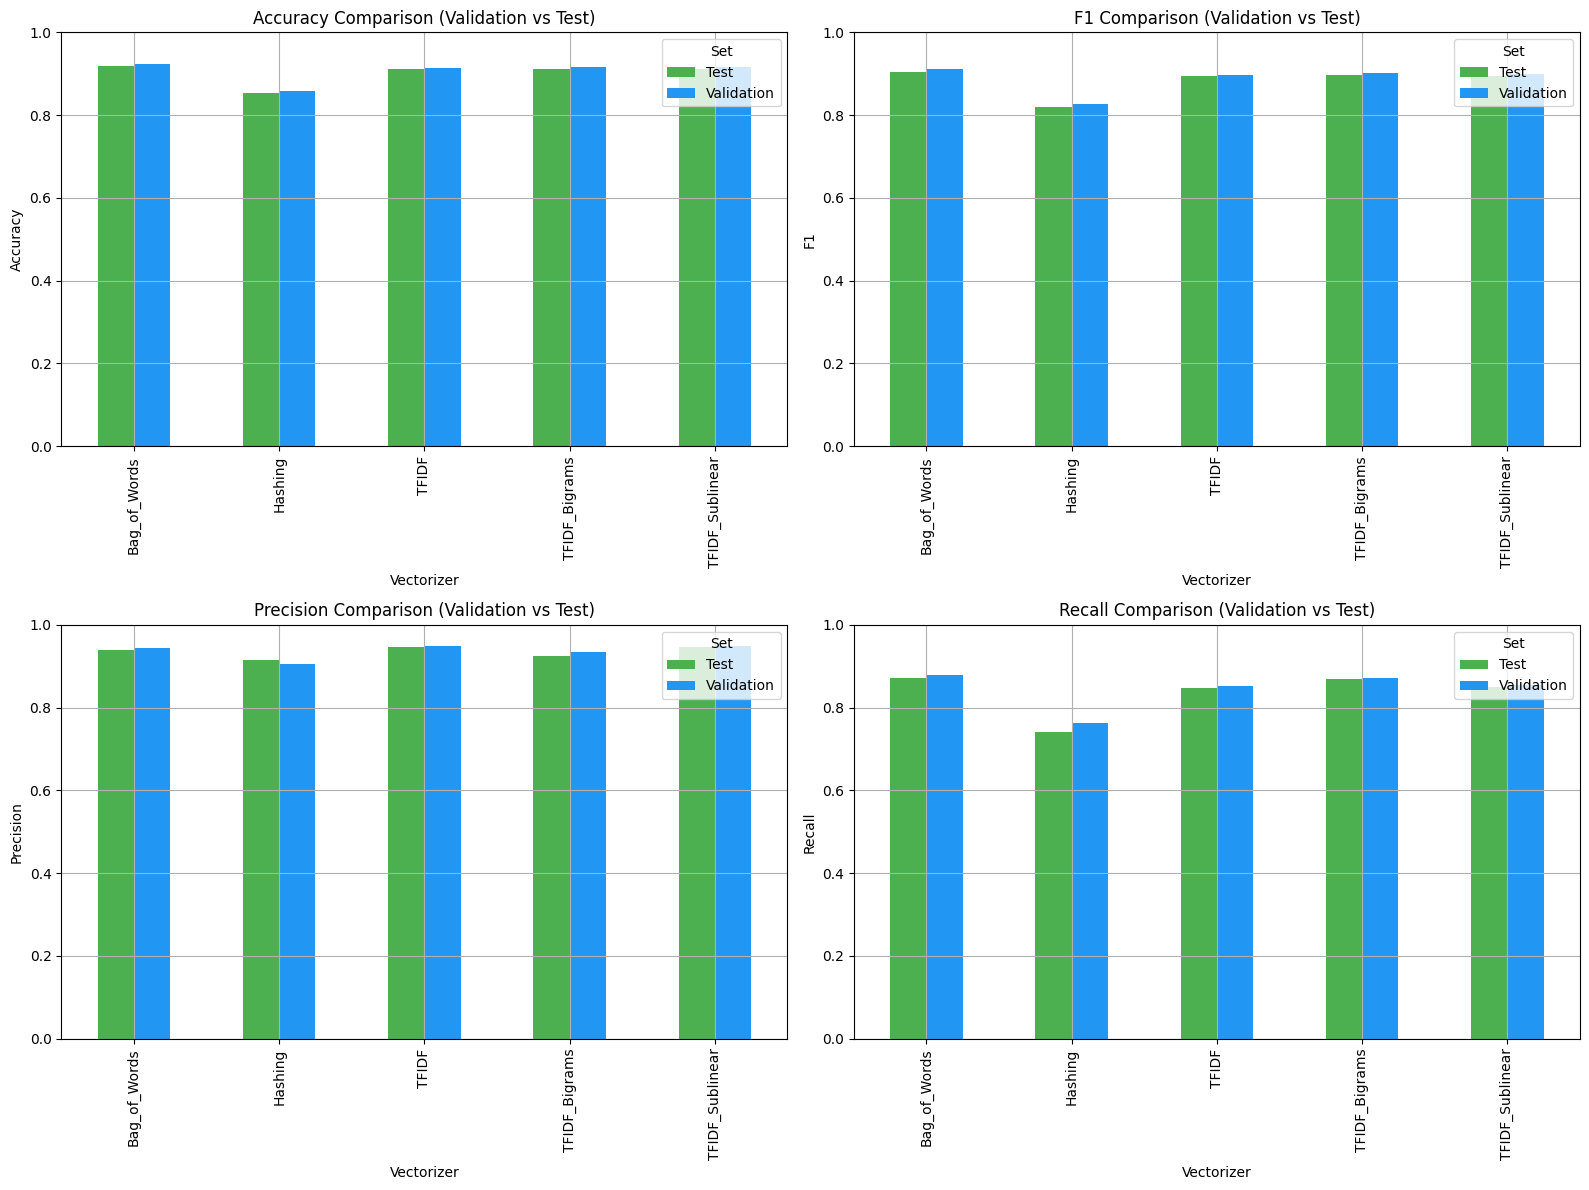

In [93]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scipy import sparse

# 📁 Ensure directories exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("plots", exist_ok=True)
os.makedirs("results", exist_ok=True)

# 📄 Load datasets
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

# ✂️ Filter short headlines
min_len = 5
train_df = train_df[train_df["clean_headline"].str.len() > min_len]
val_df = val_df[val_df["clean_headline"].str.len() > min_len]
test_df = test_df[test_df["clean_headline"].str.len() > min_len]

# 📊 Split features and labels
X_train, y_train = train_df["clean_headline"], train_df["label_encoded"]
X_val, y_val = val_df["clean_headline"], val_df["label_encoded"]
X_test, y_test = test_df["clean_headline"], test_df["label_encoded"]

# 🔤 Vectorizer configs
vectorizers = {
    "Bag_of_Words": CountVectorizer(),
    "TFIDF": TfidfVectorizer(),
    "TFIDF_Sublinear": TfidfVectorizer(sublinear_tf=True),
    "TFIDF_Bigrams": TfidfVectorizer(ngram_range=(1, 2)),
    "Hashing": HashingVectorizer(n_features=2**18, alternate_sign=False)
}

# 📈 Model pipeline components
svd = TruncatedSVD(n_components=100)
model = LogisticRegression(max_iter=200)
results = []

# 🔁 Evaluate each vectorizer
for name, vectorizer in vectorizers.items():
    print(f"🔍 Evaluating {name}...")

    pipeline = make_pipeline(vectorizer, svd, model) if name == "Hashing" else make_pipeline(vectorizer, model)
    pipeline.fit(X_train, y_train)

    vec_name = vectorizer.__class__.__name__.lower()

    try:
        vec_obj = pipeline.named_steps[vec_name]
        X_train_vec = vec_obj.transform(X_train)
        X_val_vec = vec_obj.transform(X_val)
        X_test_vec = vec_obj.transform(X_test)

        # Save vectors as compressed sparse format
        sparse.save_npz(f'vectors/X_train_{name}.npz', X_train_vec)
        sparse.save_npz(f'vectors/X_val_{name}.npz', X_val_vec)
        sparse.save_npz(f'vectors/X_test_{name}.npz', X_test_vec)

    except Exception as e:
        print(f"⚠️ Skipped saving vectors for {name} due to error: {e}")

    # Evaluate on val & test
    for split_name, X_eval, y_eval in [("Validation", X_val, y_val), ("Test", X_test, y_test)]:
        y_pred = pipeline.predict(X_eval)
        results.append({
            "Vectorizer": name,
            "Set": split_name,
            "Accuracy": accuracy_score(y_eval, y_pred),
            "Precision": precision_score(y_eval, y_pred),
            "Recall": recall_score(y_eval, y_pred),
            "F1": f1_score(y_eval, y_pred)
        })

# 💾 Save metrics
results_df = pd.DataFrame(results)
results_df.to_csv("results/traditional_vectorizer_results.csv", index=False)
print(results_df)

# 📊 Plotting
metrics = ["Accuracy", "F1", "Precision", "Recall"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, metric in enumerate(metrics):
    ax = axes[i // 2][i % 2]
    pivot = results_df.pivot(index="Vectorizer", columns="Set", values=metric)
    pivot.plot(kind="bar", ax=ax, color=["#4caf50", "#2196f3"])
    ax.set_title(f"{metric} Comparison (Validation vs Test)")
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.grid(True)

plt.tight_layout()
plt.savefig("plots/traditional_vectorizer_plot.png", dpi=300)
plt.show()

Batches:   0%|          | 0/1349 [00:00<?, ?it/s]

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

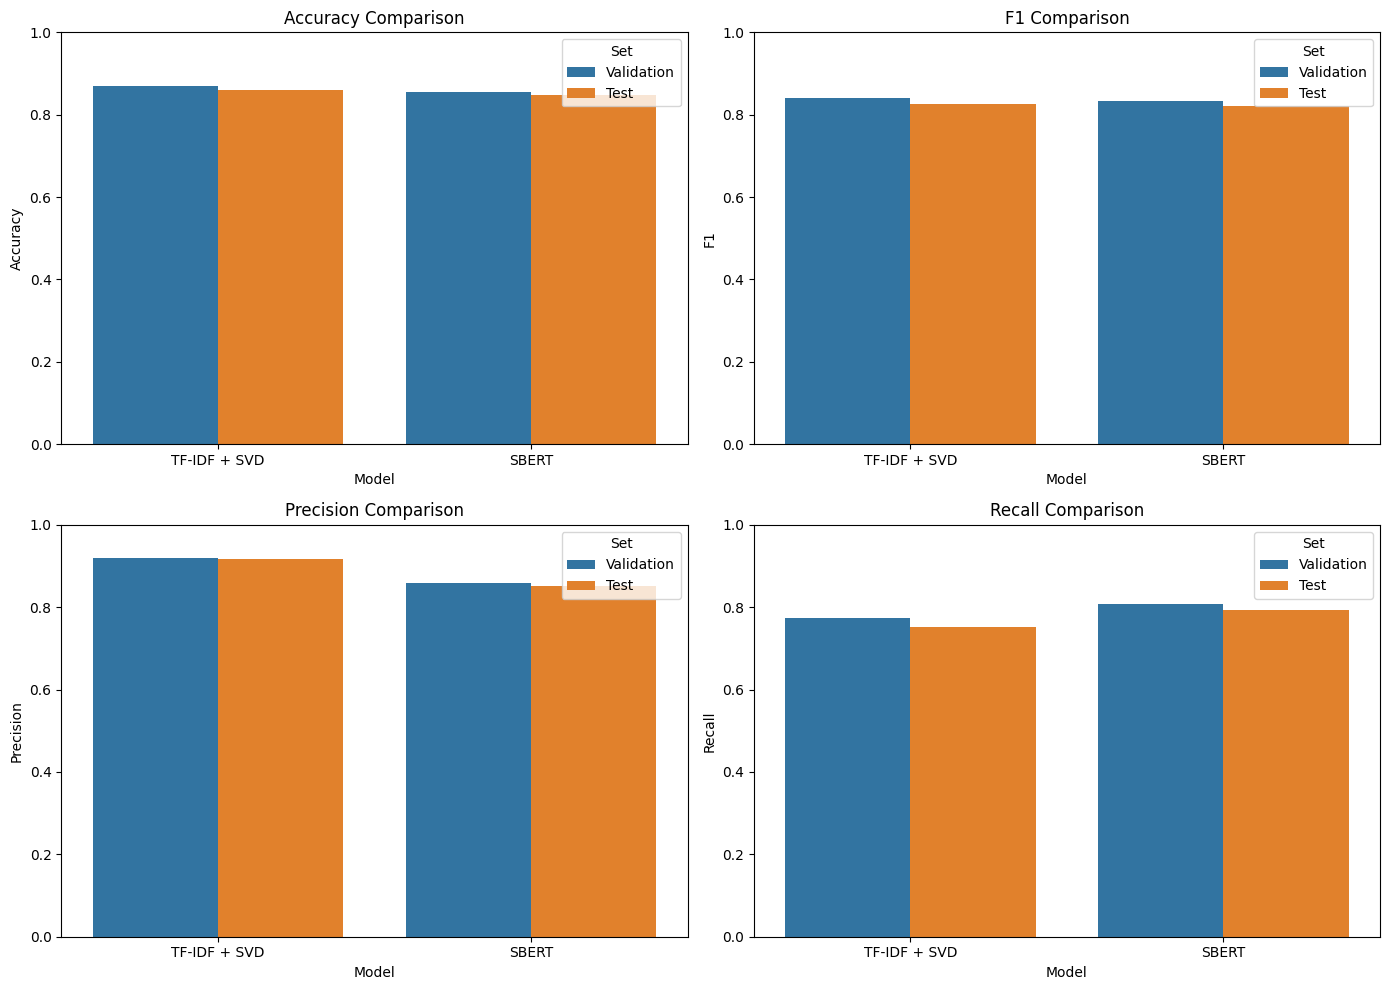

Model         Set  Accuracy  Precision    Recall        F1
0  TF-IDF + SVD  Validation  0.869694   0.920477  0.773278  0.840481
1  TF-IDF + SVD        Test  0.858970   0.916031  0.751252  0.825499
2         SBERT  Validation  0.855607   0.859111  0.807098  0.832293
3         SBERT        Test  0.847294   0.852151  0.793823  0.821953

In [94]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# 📂 Ensure output directories exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# 📂 Load processed datasets
train_df = pd.read_csv("data/processed_train.csv")
val_df = pd.read_csv("data/processed_val.csv")
test_df = pd.read_csv("data/processed_test.csv")

X_train = train_df["clean_headline"].fillna("")
y_train = train_df["label_encoded"]
X_val = val_df["clean_headline"].fillna("")
y_val = val_df["label_encoded"]
X_test = test_df["clean_headline"].fillna("")
y_test = test_df["label_encoded"]

# ✅ TF-IDF + SVD + Logistic Regression
tfidf = TfidfVectorizer()
svd = TruncatedSVD(n_components=100)
lr_model = LogisticRegression(max_iter=200)
tfidf_pipeline = make_pipeline(tfidf, svd, lr_model)
tfidf_pipeline.fit(X_train, y_train)

val_pred_tfidf = tfidf_pipeline.predict(X_val)
test_pred_tfidf = tfidf_pipeline.predict(X_test)

# Optional: save SVD-reduced vectors
X_train_tfidf_svd = tfidf_pipeline[:-1].transform(X_train)
X_val_tfidf_svd = tfidf_pipeline[:-1].transform(X_val)
X_test_tfidf_svd = tfidf_pipeline[:-1].transform(X_test)
np.save("vectors/X_train_tfidf_svd.npy", X_train_tfidf_svd)
np.save("vectors/X_val_tfidf_svd.npy", X_val_tfidf_svd)
np.save("vectors/X_test_tfidf_svd.npy", X_test_tfidf_svd)

# ✅ SBERT Embeddings + Logistic Regression
bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_val_bert = bert_model.encode(X_val.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

np.save("vectors/X_train_sbert.npy", X_train_bert)
np.save("vectors/X_val_sbert.npy", X_val_bert)
np.save("vectors/X_test_sbert.npy", X_test_bert)

lr_bert = LogisticRegression(max_iter=200)
lr_bert.fit(X_train_bert, y_train)
val_pred_bert = lr_bert.predict(X_val_bert)
test_pred_bert = lr_bert.predict(X_test_bert)

# 📊 Compile evaluation metrics
results = pd.DataFrame([
    {"Model": "TF-IDF + SVD", "Set": "Validation", "Accuracy": accuracy_score(y_val, val_pred_tfidf),
     "Precision": precision_score(y_val, val_pred_tfidf), "Recall": recall_score(y_val, val_pred_tfidf),
     "F1": f1_score(y_val, val_pred_tfidf)},
    {"Model": "TF-IDF + SVD", "Set": "Test", "Accuracy": accuracy_score(y_test, test_pred_tfidf),
     "Precision": precision_score(y_test, test_pred_tfidf), "Recall": recall_score(y_test, test_pred_tfidf),
     "F1": f1_score(y_test, test_pred_tfidf)},
    {"Model": "SBERT", "Set": "Validation", "Accuracy": accuracy_score(y_val, val_pred_bert),
     "Precision": precision_score(y_val, val_pred_bert), "Recall": recall_score(y_val, val_pred_bert),
     "F1": f1_score(y_val, val_pred_bert)},
    {"Model": "SBERT", "Set": "Test", "Accuracy": accuracy_score(y_test, test_pred_bert),
     "Precision": precision_score(y_test, test_pred_bert), "Recall": recall_score(y_test, test_pred_bert),
     "F1": f1_score(y_test, test_pred_bert)},
])

# 💾 Save results
results.to_csv("results/tf_svd_embeddings_results.csv", index=False)

# 📊 Plotting
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Accuracy", "F1", "Precision", "Recall"]
for i, metric in enumerate(metrics):
    ax = axes[i // 2][i % 2]
    sns.barplot(data=results, x="Model", y=metric, hue="Set", ax=ax)
    ax.set_title(f"{metric} Comparison")
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)

plt.tight_layout()
plt.savefig("plots/tf_svd_embeddings_plot.png", dpi=300)
plt.show()

# 📋 Final Table
results


Character-Level TF-IDF Results:

          Set  Accuracy  Precision    Recall        F1
0  Validation  0.910287   0.946704  0.845511  0.893251
1        Test  0.904541   0.941315  0.837161  0.886188


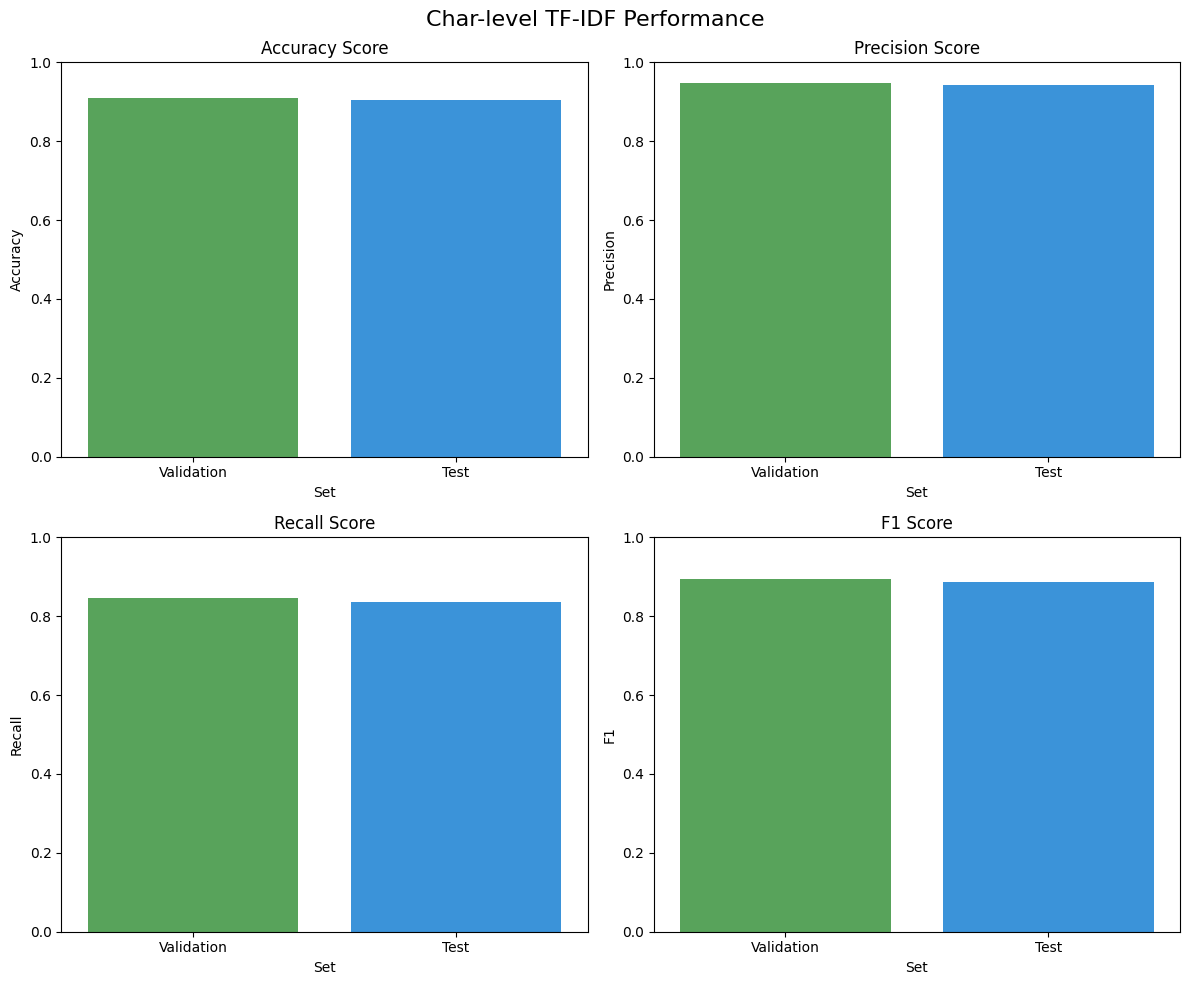

In [95]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

# 📂 Load data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline"])
val_df = pd.read_csv("data/processed_val.csv").dropna(subset=["clean_headline"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline"])

X_train_texts = train_df["clean_headline"].astype(str)
X_val_texts = val_df["clean_headline"].astype(str)
X_test_texts = test_df["clean_headline"].astype(str)

y_train = train_df["label_encoded"]
y_val = val_df["label_encoded"]
y_test = test_df["label_encoded"]

# ✅ Vectorization
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 5))
X_train_char = char_vectorizer.fit_transform(X_train_texts)
X_val_char = char_vectorizer.transform(X_val_texts)
X_test_char = char_vectorizer.transform(X_test_texts)

# 💾 Save sparse matrices
os.makedirs("vectors", exist_ok=True)
sparse.save_npz("vectors/X_train_char_tfidf.npz", X_train_char)
sparse.save_npz("vectors/X_val_char_tfidf.npz", X_val_char)
sparse.save_npz("vectors/X_test_char_tfidf.npz", X_test_char)

# ✅ Train & evaluate
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_char, y_train)

val_preds = clf.predict(X_val_char)
test_preds = clf.predict(X_test_char)

# 📊 Metrics
results = pd.DataFrame([
    {"Set": "Validation", "Accuracy": accuracy_score(y_val, val_preds),
     "Precision": precision_score(y_val, val_preds), "Recall": recall_score(y_val, val_preds),
     "F1": f1_score(y_val, val_preds)},
    {"Set": "Test", "Accuracy": accuracy_score(y_test, test_preds),
     "Precision": precision_score(y_test, test_preds), "Recall": recall_score(y_test, test_preds),
     "F1": f1_score(y_test, test_preds)}
])
results.to_csv("results/char_tfidf_results.csv", index=False)

print("\nCharacter-Level TF-IDF Results:\n")
print(results)

# 📈 Plotting
os.makedirs("plots", exist_ok=True)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ["Accuracy", "Precision", "Recall", "F1"]

for i, metric in enumerate(metrics):
    ax = axes[i // 2][i % 2]
    sns.barplot(data=results, x="Set", y=metric, hue="Set", ax=ax, palette=["#4caf50", "#2196f3"], legend=False)
    ax.set_title(f"{metric} Score")
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric)

plt.suptitle("Char-level TF-IDF Performance", fontsize=16)
plt.tight_layout()
plt.savefig("plots/char_tfidf_eval.png", dpi=300)
plt.show()

In [79]:
import importlib
import gensim
importlib.reload(gensim)
from gensim.models import Word2Vec

In [80]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import gensim.downloader as api
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
import tensorflow as tf

In [81]:
# ✅ Load + clean utility
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load datasets
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

In [86]:
import os
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Create required folders
os.makedirs("vectors", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ✅ Utility to load and clean datasets
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load train/val/test data
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

# ✅ Train Word2Vec on tokenized training data
train_tokens = [text.split() for text in X_train_text]
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, seed=42)

# ✅ Average vector representation for each document
def avg_w2v(tokens, model, k=100):
    valid = [w for w in tokens if w in model.wv]
    return np.mean([model.wv[w] for w in valid], axis=0) if valid else np.zeros(k)

# ✅ Transform all splits
X_train_w2v = np.array([avg_w2v(t.split(), w2v_model) for t in X_train_text])
X_val_w2v   = np.array([avg_w2v(t.split(), w2v_model) for t in X_val_text])
X_test_w2v  = np.array([avg_w2v(t.split(), w2v_model) for t in X_test_text])

# ✅ Save embeddings
np.save("vectors/X_train_word2vec.npy", X_train_w2v)
np.save("vectors/X_val_word2vec.npy", X_val_w2v)
np.save("vectors/X_test_word2vec.npy", X_test_w2v)

# ✅ Train and evaluate model
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_w2v, y_train)

val_preds  = clf.predict(X_val_w2v)
test_preds = clf.predict(X_test_w2v)

# ✅ Classification reports
val_report  = classification_report(y_val, val_preds, output_dict=True)
test_report = classification_report(y_test, test_preds, output_dict=True)

# ✅ Save reports to CSV
pd.DataFrame(val_report).transpose().to_csv("results/word2vec_val_report.csv", index=True)
pd.DataFrame(test_report).transpose().to_csv("results/word2vec_test_report.csv", index=True)

# ✅ Print summary
print("✅ Word2Vec evaluation complete.")
print("Validation Accuracy:", val_report["accuracy"])
print("Test Accuracy     :", test_report["accuracy"])

✅ Word2Vec evaluation complete.
Validation Accuracy: 0.871177015755329
Test Accuracy     : 0.8641334569045412


In [87]:
import os
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Ensure output directories exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ✅ Utility to load and clean datasets
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load train/val/test data
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

# ✅ Step 1: Prepare Tagged Documents
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train_text)]

# ✅ Step 2: Train Doc2Vec model
doc2vec_model = Doc2Vec(
    documents, vector_size=100, window=5, min_count=2, epochs=30, seed=42
)

# ✅ Step 3: Generate embeddings
X_train_doc2vec = np.array([doc2vec_model.infer_vector(t.split()) for t in X_train_text])
X_val_doc2vec   = np.array([doc2vec_model.infer_vector(t.split()) for t in X_val_text])
X_test_doc2vec  = np.array([doc2vec_model.infer_vector(t.split()) for t in X_test_text])

# ✅ Step 4: Save embeddings
np.save("vectors/X_train_doc2vec.npy", X_train_doc2vec)
np.save("vectors/X_val_doc2vec.npy", X_val_doc2vec)
np.save("vectors/X_test_doc2vec.npy", X_test_doc2vec)

# ✅ Step 5: Train & Evaluate
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_doc2vec, y_train)

val_preds  = clf.predict(X_val_doc2vec)
test_preds = clf.predict(X_test_doc2vec)

val_report  = classification_report(y_val, val_preds, output_dict=True)
test_report = classification_report(y_test, test_preds, output_dict=True)

# ✅ Step 6: Save reports to CSV
pd.DataFrame(val_report).transpose().to_csv("results/doc2vec_val_report.csv", index=True)
pd.DataFrame(test_report).transpose().to_csv("results/doc2vec_test_report.csv", index=True)

# ✅ Summary
print("✅ Doc2Vec evaluation complete.")
print("Validation Accuracy:", val_report["accuracy"])
print("Test Accuracy     :", test_report["accuracy"])

✅ Doc2Vec evaluation complete.
Validation Accuracy: 0.7747914735866543
Test Accuracy     : 0.7718257645968489


In [88]:
import os
import numpy as np
import pandas as pd
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Ensure output directories exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ✅ Utility to load and clean datasets
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load datasets
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

# ✅ Download pre-trained FastText model (first time takes ~4GB)
ft_model = api.load("fasttext-wiki-news-subwords-300")

# ✅ Embedding Function
def fasttext_avg(text, model, k=300):
    words = text.split()
    valid = [model[w] for w in words if w in model]
    return np.mean(valid, axis=0) if valid else np.zeros(k)

# ✅ Generate embeddings
X_train_ft = np.array([fasttext_avg(t, ft_model) for t in X_train_text])
X_val_ft   = np.array([fasttext_avg(t, ft_model) for t in X_val_text])
X_test_ft  = np.array([fasttext_avg(t, ft_model) for t in X_test_text])

# ✅ Save .npy embeddings
np.save("vectors/X_train_fasttext.npy", X_train_ft)
np.save("vectors/X_val_fasttext.npy", X_val_ft)
np.save("vectors/X_test_fasttext.npy", X_test_ft)

# ✅ Train and evaluate model
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_ft, y_train)

val_preds  = clf.predict(X_val_ft)
test_preds = clf.predict(X_test_ft)

val_report  = classification_report(y_val, val_preds, output_dict=True)
test_report = classification_report(y_test, test_preds, output_dict=True)

# ✅ Save reports
pd.DataFrame(val_report).transpose().to_csv("results/fasttext_val_report.csv", index=True)
pd.DataFrame(test_report).transpose().to_csv("results/fasttext_test_report.csv", index=True)

# ✅ Summary
print("✅ FastText evaluation complete.")
print("Validation Accuracy:", val_report["accuracy"])
print("Test Accuracy     :", test_report["accuracy"])

✅ FastText evaluation complete.
Validation Accuracy: 0.8509731232622799
Test Accuracy     : 0.8405931417979611


In [89]:
import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Ensure output folders exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ✅ Utility to load and clean data
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load data
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

# ✅ Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# ✅ Generate embeddings
X_train_sbert = sbert_model.encode(X_train_text.tolist(), show_progress_bar=True)
X_val_sbert   = sbert_model.encode(X_val_text.tolist(), show_progress_bar=True)
X_test_sbert  = sbert_model.encode(X_test_text.tolist(), show_progress_bar=True)

# 💾 Save embeddings
np.save("vectors/X_train_sbert.npy", X_train_sbert)
np.save("vectors/X_val_sbert.npy", X_val_sbert)
np.save("vectors/X_test_sbert.npy", X_test_sbert)

# ✅ Train and evaluate model
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_sbert, y_train)

val_preds  = clf.predict(X_val_sbert)
test_preds = clf.predict(X_test_sbert)

val_report  = classification_report(y_val, val_preds, output_dict=True)
test_report = classification_report(y_test, test_preds, output_dict=True)

# 💾 Save reports
pd.DataFrame(val_report).transpose().to_csv("results/sbert_val_report.csv", index=True)
pd.DataFrame(test_report).transpose().to_csv("results/sbert_test_report.csv", index=True)

# ✅ Print summary
print("✅ SBERT evaluation complete.")
print("Validation Accuracy:", val_report["accuracy"])
print("Test Accuracy     :", test_report["accuracy"])

Batches:   0%|          | 0/1349 [00:00<?, ?it/s]

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

✅ SBERT evaluation complete.
Validation Accuracy: 0.8559777571825764
Test Accuracy     : 0.8472659870250232


In [90]:
import os
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# ✅ Ensure folders exist
os.makedirs("vectors", exist_ok=True)
os.makedirs("results", exist_ok=True)

# ✅ Utility to load and clean dataset
def load_and_clean_df(path):
    df = pd.read_csv(path)
    df_clean = df.dropna(subset=["clean_headline"])
    X_text = df_clean["clean_headline"].astype(str)
    y = df_clean["label_encoded"].values
    return X_text, y

# ✅ Load datasets
X_train_text, y_train = load_and_clean_df("data/processed_train.csv")
X_val_text, y_val     = load_and_clean_df("data/processed_val.csv")
X_test_text, y_test   = load_and_clean_df("data/processed_test.csv")

# ✅ Load USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# ✅ Generate embeddings
X_train_use = use_model(X_train_text.tolist()).numpy()
X_val_use   = use_model(X_val_text.tolist()).numpy()
X_test_use  = use_model(X_test_text.tolist()).numpy()

# 💾 Save .npy embeddings
np.save("vectors/X_train_use.npy", X_train_use)
np.save("vectors/X_val_use.npy", X_val_use)
np.save("vectors/X_test_use.npy", X_test_use)

# ✅ Train and evaluate
clf = LogisticRegression(max_iter=300)
clf.fit(X_train_use, y_train)

val_preds  = clf.predict(X_val_use)
test_preds = clf.predict(X_test_use)

val_report  = classification_report(y_val, val_preds, output_dict=True)
test_report = classification_report(y_test, test_preds, output_dict=True)

# 💾 Save reports
pd.DataFrame(val_report).transpose().to_csv("results/use_val_report.csv", index=True)
pd.DataFrame(test_report).transpose().to_csv("results/use_test_report.csv", index=True)

# ✅ Print summary
print("✅ USE evaluation complete.")
print("Validation Accuracy:", val_report["accuracy"])
print("Test Accuracy     :", test_report["accuracy"])

✅ USE evaluation complete.
Validation Accuracy: 0.8539388322520852
Test Accuracy     : 0.8513438368860056


✅ Val samples loaded: 5395
🔍 Val | Processing Word2Vec...
   📐 Embeddings: (5395, 100), Labels: 5395
🔍 Val | Processing FastText...
   📐 Embeddings: (5395, 300), Labels: 5395
🔍 Val | Processing Doc2Vec...
   📐 Embeddings: (5395, 100), Labels: 5395
🔍 Val | Processing SBERT...
   📐 Embeddings: (5395, 384), Labels: 5395
🔍 Val | Processing USE...
   📐 Embeddings: (5395, 512), Labels: 5395


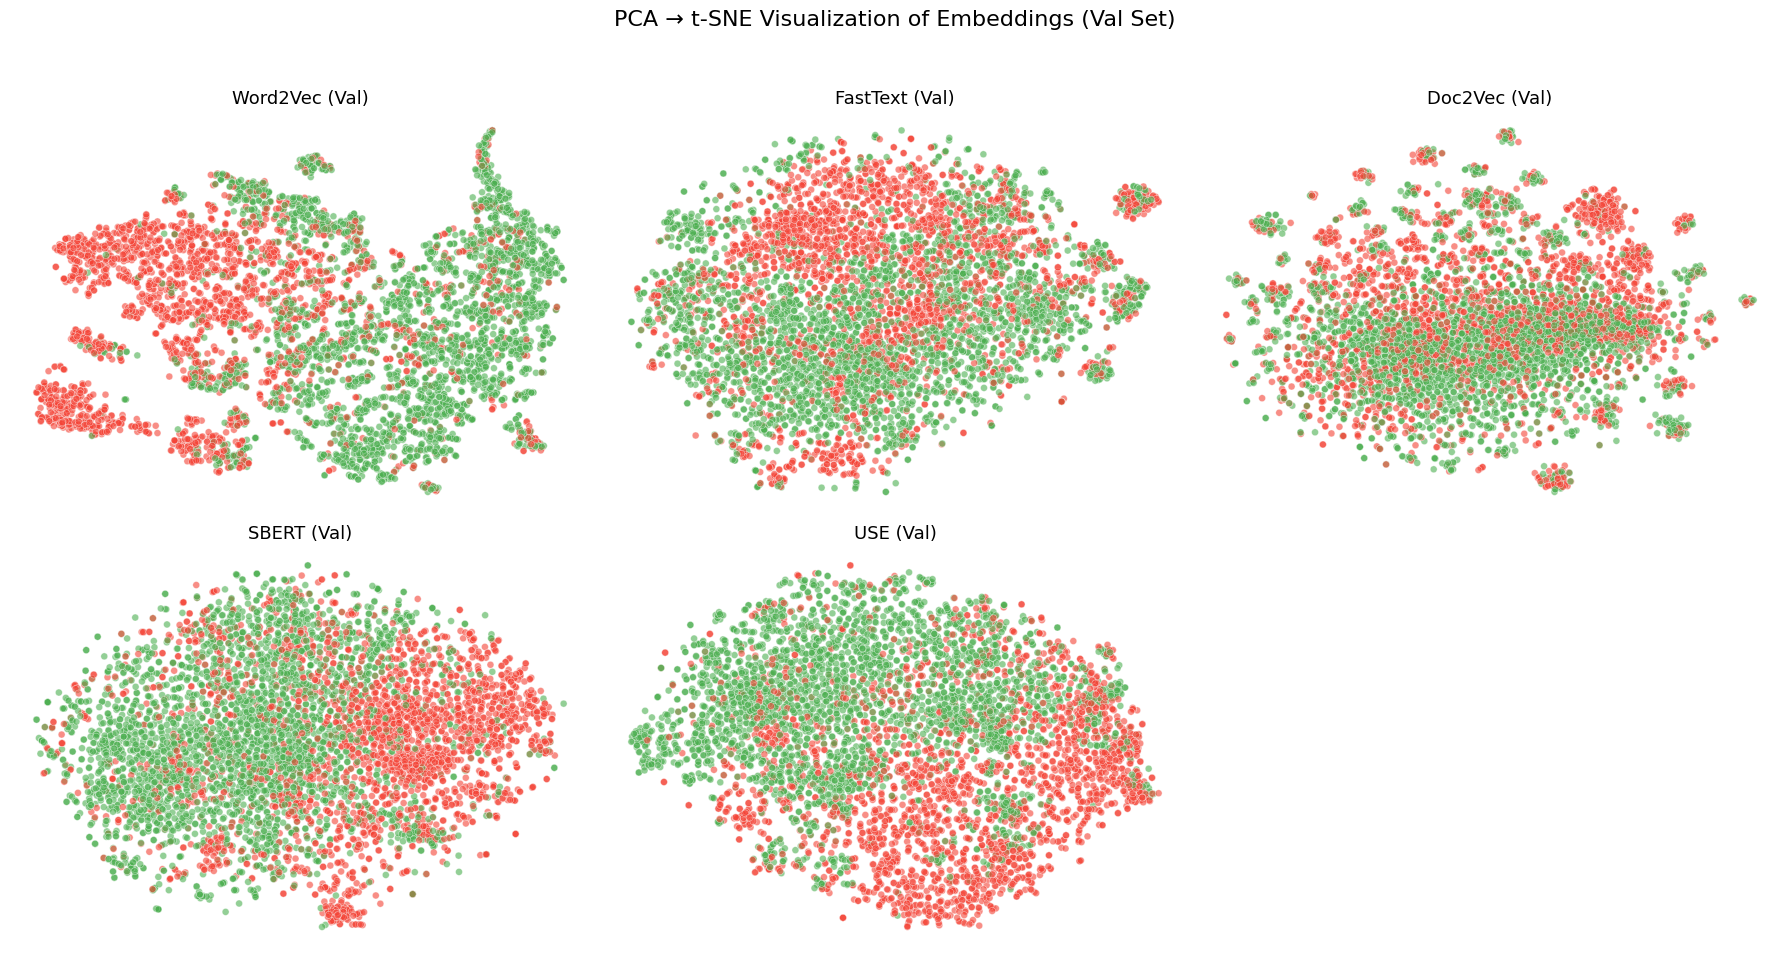

✅ Test samples loaded: 5395
🔍 Test | Processing Word2Vec...
   📐 Embeddings: (5395, 100), Labels: 5395
🔍 Test | Processing FastText...
   📐 Embeddings: (5395, 300), Labels: 5395
🔍 Test | Processing Doc2Vec...
   📐 Embeddings: (5395, 100), Labels: 5395
🔍 Test | Processing SBERT...
   📐 Embeddings: (5395, 384), Labels: 5395
🔍 Test | Processing USE...
   📐 Embeddings: (5395, 512), Labels: 5395


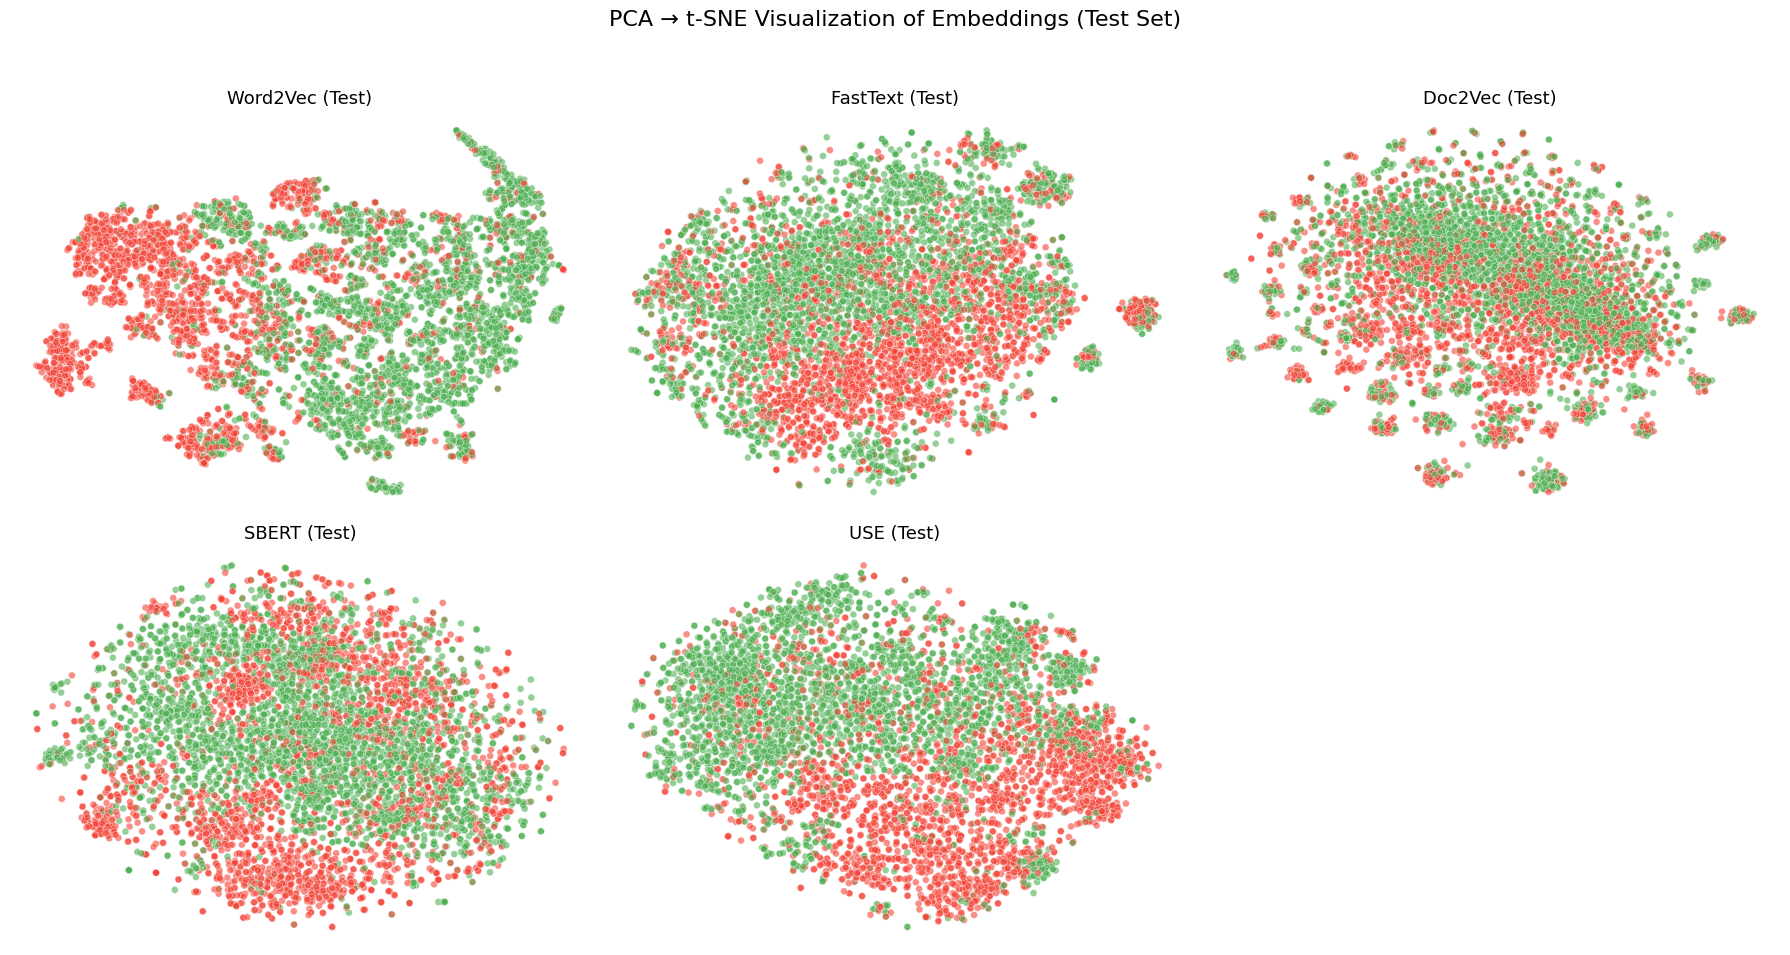

In [92]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 📂 Ensure folders exist
os.makedirs("vectors/tsne", exist_ok=True)

# ✅ Label and color mappings
label_map = {0: "Real", 1: "Fake"}
palette = {"Real": "#4caf50", "Fake": "#f44336"}

# ✅ Load labels
def load_labels(split):
    df = pd.read_csv(f"data/processed_{split}.csv")
    return df["label_encoded"].values

# ✅ Generate t-SNE for a single embedding and split
def generate_tsne_for_embedding(name, split, path, y_labels):
    print(f"🔍 {split} | Processing {name}...")
    X = np.load(path)

    if len(X) != len(y_labels):
        print(f"⚠️ Skipping {name} ({split}) due to mismatched shapes: {len(X)} != {len(y_labels)}")
        return None

    X_pca = PCA(n_components=50, random_state=42).fit_transform(X)
    X_tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42).fit_transform(X_pca)
    np.save(f"vectors/tsne/{name}_tsne_{split}.npy", X_tsne)

    df = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
    df["Label"] = [label_map[y] for y in y_labels]
    return df

# ✅ Plot all t-SNEs for one split
def plot_combined_tsne(mode, embedding_paths_dict):
    """
    mode: "val" or "test"
    embedding_paths_dict: dict { "VectorizerName": path_to_npy }
    """
    assert mode in ["val", "test"], "Mode must be 'val' or 'test'"
    
    # Load and clean labels
    if mode == "val":
        df = pd.read_csv("data/processed_val.csv")
    else:
        df = pd.read_csv("data/processed_test.csv")
        df = df.dropna(subset=["clean_headline"])
        df = df[df["clean_headline"].str.strip() != ""]

    y = df["label_encoded"].values
    print(f"✅ {mode.title()} samples loaded: {len(y)}")

    label_map = {0: "Real", 1: "Fake"}
    palette = {"Real": "#4caf50", "Fake": "#f44336"}

    os.makedirs("plots", exist_ok=True)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, (name, path) in enumerate(embedding_paths_dict.items()):
        print(f"🔍 {mode.title()} | Processing {name}...")

        try:
            X = np.load(path)
        except Exception as e:
            print(f"❌ Error loading {path}: {e}")
            continue

        print(f"   📐 Embeddings: {X.shape}, Labels: {len(y)}")

        if len(X) != len(y):
            print(f"⚠️ Skipping {name} due to mismatched shapes: {len(X)} != {len(y)}")
            continue

        X_pca = PCA(n_components=50, random_state=42).fit_transform(X)
        X_tsne = TSNE(n_components=2, perplexity=30, init="pca", random_state=42).fit_transform(X_pca)
        np.save(f"plots/{name}_tsne_{mode}.npy", X_tsne)

        df_plot = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"])
        df_plot["Label"] = [label_map[label] for label in y]

        ax = axes[i]
        sns.scatterplot(
            data=df_plot, x="Dim1", y="Dim2", hue="Label", palette=palette,
            s=25, alpha=0.6, ax=ax, legend=False
        )
        ax.set_title(f"{name} ({mode.title()})", fontsize=13)
        ax.axis("off")

    if len(embedding_paths_dict) < len(axes):
        axes[-1].axis("off")

    plt.suptitle(f"PCA → t-SNE Visualization of Embeddings ({mode.title()} Set)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"plots/all_tsne_{mode}.png", dpi=300)
    plt.show()


# ✅ Define embedding paths
val_paths = {
    "Word2Vec": "vectors/X_val_word2vec.npy",
    "FastText": "vectors/X_val_fasttext.npy",
    "Doc2Vec": "vectors/X_val_doc2vec.npy",
    "SBERT": "vectors/X_val_sbert.npy",
    "USE": "vectors/X_val_use.npy",
}

test_paths = {
    "Word2Vec": "vectors/X_test_word2vec.npy",
    "FastText": "vectors/X_test_fasttext.npy",
    "Doc2Vec": "vectors/X_test_doc2vec.npy",
    "SBERT": "vectors/X_test_sbert.npy",
    "USE": "vectors/X_test_use.npy",
}

# 🚀 Run
plot_combined_tsne("val", val_paths)
plot_combined_tsne("test", test_paths)

[{'Model': 'BoW', 'Set': 'Validation', 'Accuracy': 0.9232, 'Precision': 0.9435, 'Recall': 0.8796, 'F1': 0.9105, 'F1_std': 0.004}, {'Model': 'BoW', 'Set': 'Test', 'Accuracy': 0.9178, 'Precision': 0.9384, 'Recall': 0.8722, 'F1': 0.9041, 'F1_std': 0.003}, {'Model': 'TF-IDF', 'Set': 'Validation', 'Accuracy': 0.9141, 'Precision': 0.9497, 'Recall': 0.8517, 'F1': 0.898, 'F1_std': 0.003}, {'Model': 'TF-IDF', 'Set': 'Test', 'Accuracy': 0.9106, 'Precision': 0.9459, 'Recall': 0.8471, 'F1': 0.8938, 'F1_std': 0.002}, {'Model': 'TF-IDF (sublinear)', 'Set': 'Validation', 'Accuracy': 0.915, 'Precision': 0.9494, 'Recall': 0.8542, 'F1': 0.8993, 'F1_std': 0.003}, {'Model': 'TF-IDF (sublinear)', 'Set': 'Test', 'Accuracy': 0.9112, 'Precision': 0.9456, 'Recall': 0.8488, 'F1': 0.8946, 'F1_std': 0.002}, {'Model': 'TF-IDF Bigrams', 'Set': 'Validation', 'Accuracy': 0.9162, 'Precision': 0.9354, 'Recall': 0.8713, 'F1': 0.9022, 'F1_std': 0.002}, {'Model': 'TF-IDF Bigrams', 'Set': 'Test', 'Accuracy': 0.911, 'Precis

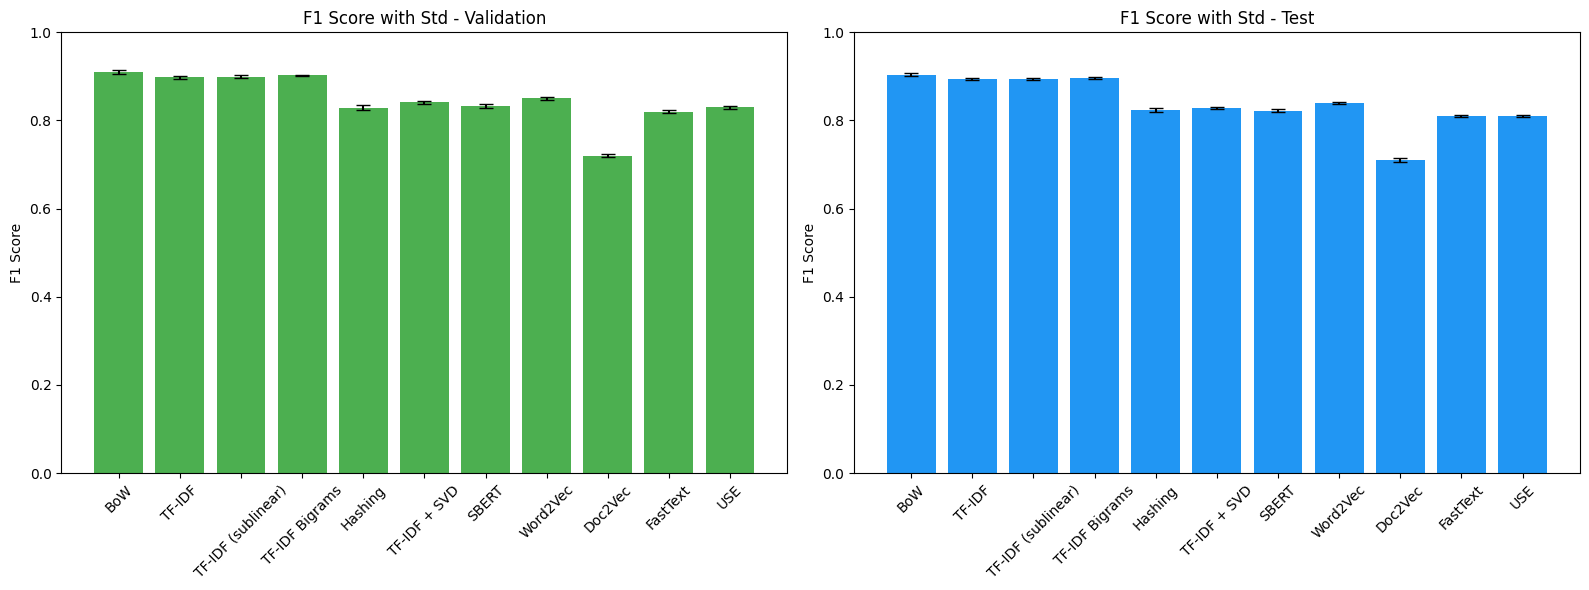

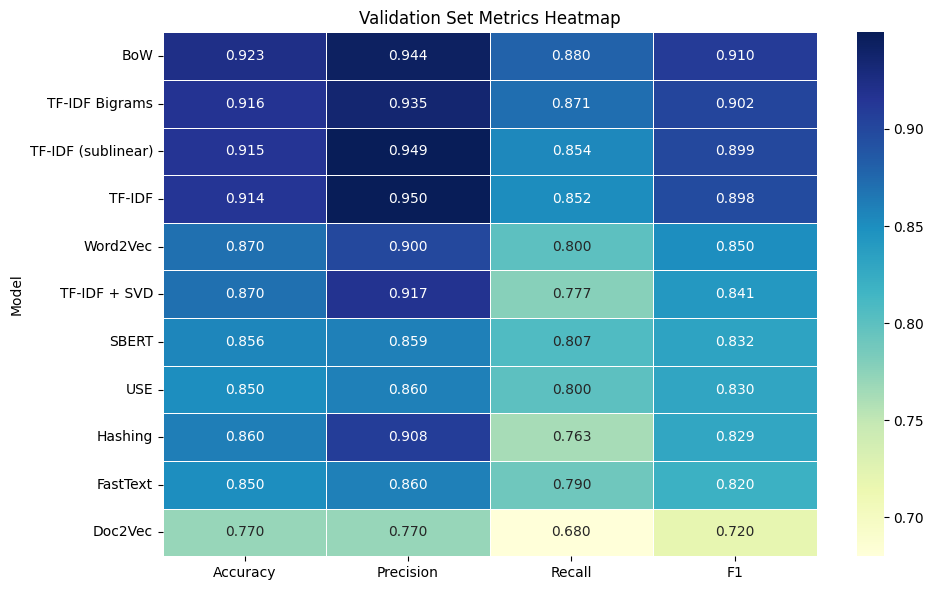

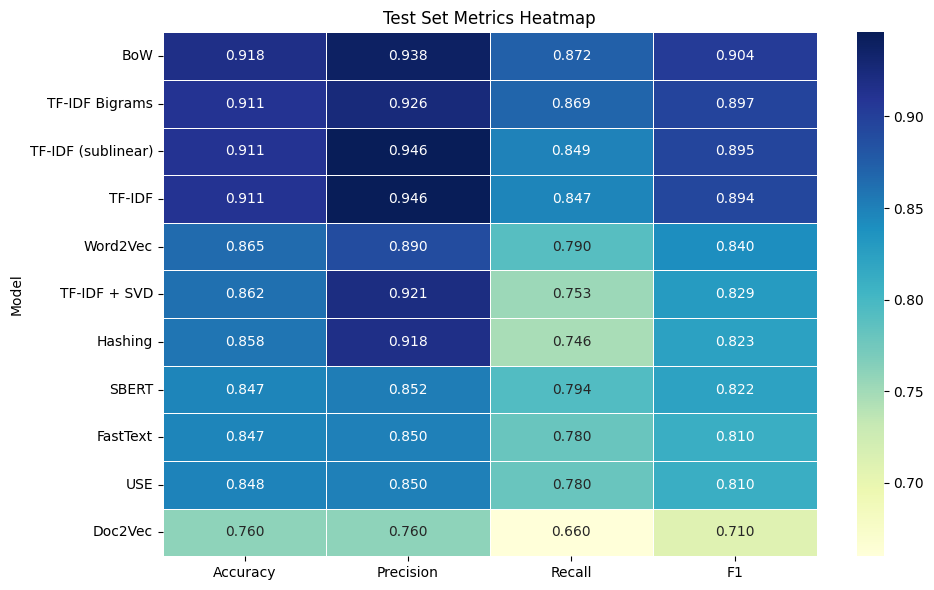

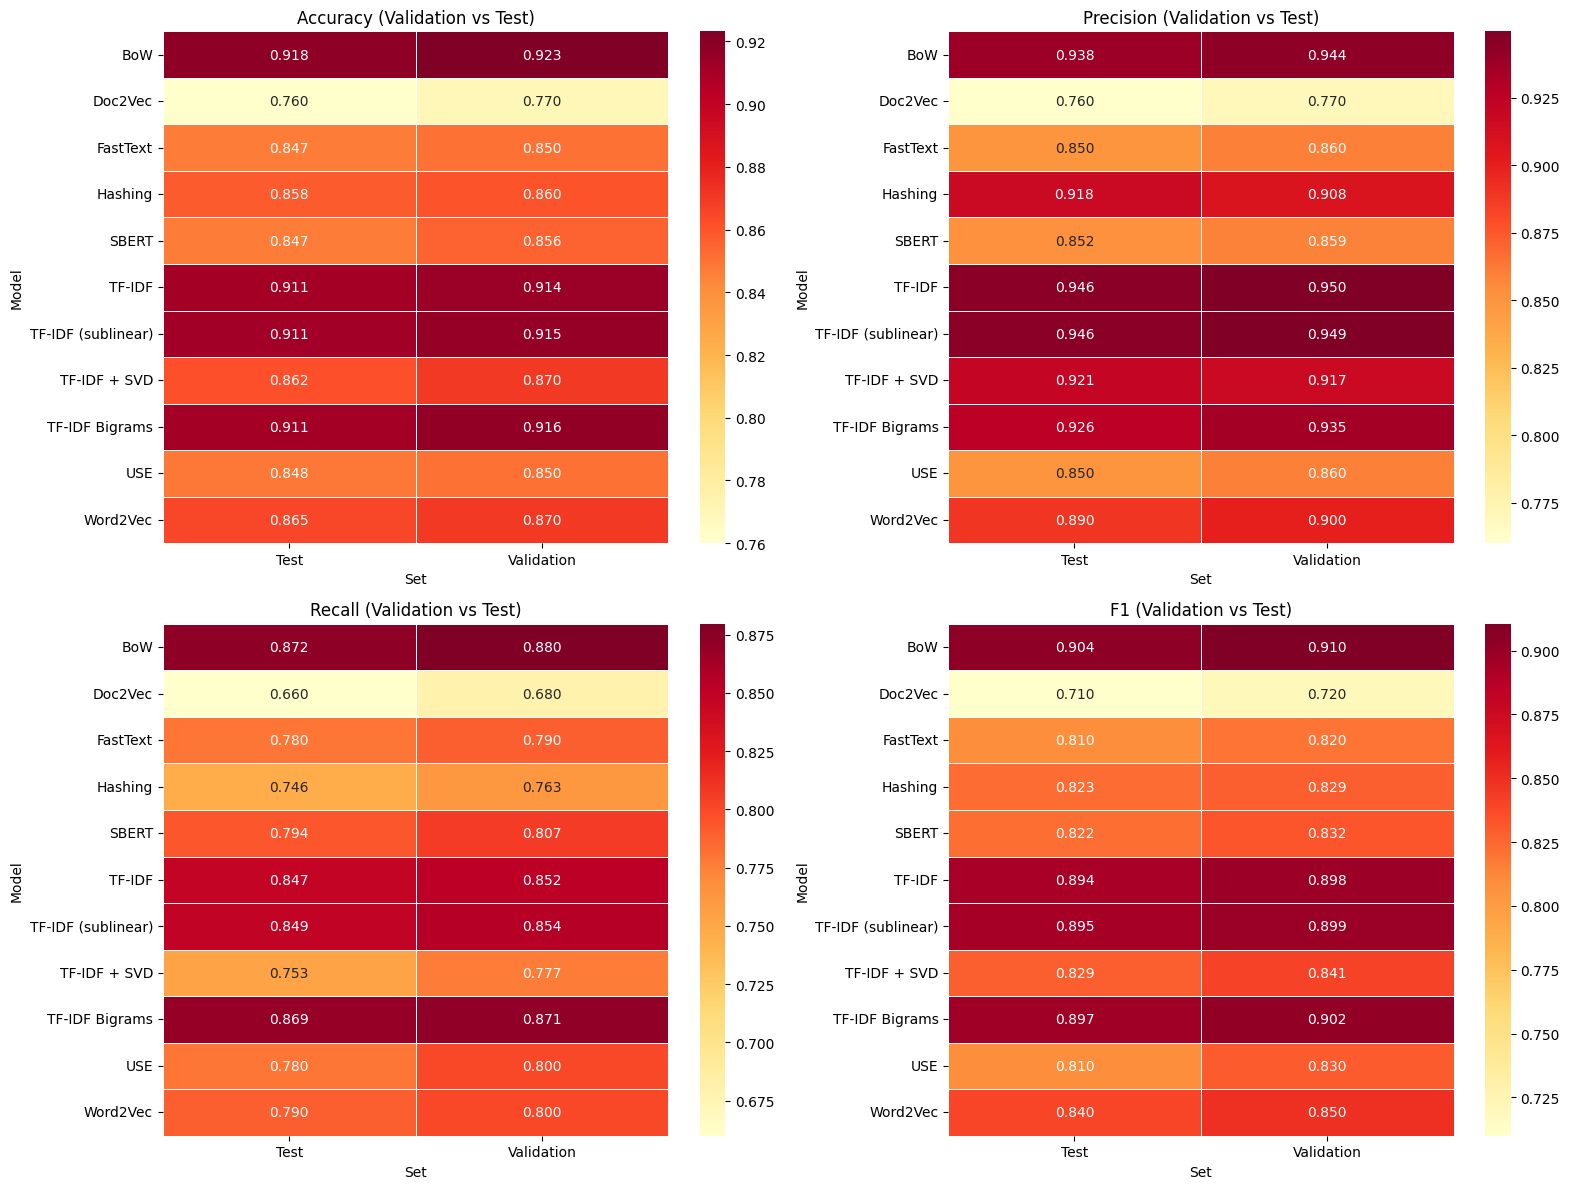

In [99]:
# 📊 Full Evaluation Script (Seaborn+Matplotlib safe)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup
os.makedirs("results", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# ✅ Your evaluation results
results = [
    {"Model": "BoW", "Set": "Validation", "Accuracy": 0.9232, "Precision": 0.9435, "Recall": 0.8796, "F1": 0.9105, "F1_std": 0.004},
    {"Model": "BoW", "Set": "Test",       "Accuracy": 0.9178, "Precision": 0.9384, "Recall": 0.8722, "F1": 0.9041, "F1_std": 0.003},
    {"Model": "TF-IDF", "Set": "Validation", "Accuracy": 0.9141, "Precision": 0.9497, "Recall": 0.8517, "F1": 0.8980, "F1_std": 0.003},
    {"Model": "TF-IDF", "Set": "Test",       "Accuracy": 0.9106, "Precision": 0.9459, "Recall": 0.8471, "F1": 0.8938, "F1_std": 0.002},
    {"Model": "TF-IDF (sublinear)", "Set": "Validation", "Accuracy": 0.9150, "Precision": 0.9494, "Recall": 0.8542, "F1": 0.8993, "F1_std": 0.003},
    {"Model": "TF-IDF (sublinear)", "Set": "Test",       "Accuracy": 0.9112, "Precision": 0.9456, "Recall": 0.8488, "F1": 0.8946, "F1_std": 0.002},
    {"Model": "TF-IDF Bigrams", "Set": "Validation", "Accuracy": 0.9162, "Precision": 0.9354, "Recall": 0.8713, "F1": 0.9022, "F1_std": 0.002},
    {"Model": "TF-IDF Bigrams", "Set": "Test",       "Accuracy": 0.9110, "Precision": 0.9257, "Recall": 0.8693, "F1": 0.8966, "F1_std": 0.002},
    {"Model": "Hashing", "Set": "Validation", "Accuracy": 0.8603, "Precision": 0.9080, "Recall": 0.7626, "F1": 0.8290, "F1_std": 0.005},
    {"Model": "Hashing", "Set": "Test",       "Accuracy": 0.8578, "Precision": 0.9178, "Recall": 0.7464, "F1": 0.8233, "F1_std": 0.004},
    {"Model": "TF-IDF + SVD", "Set": "Validation", "Accuracy": 0.8699, "Precision": 0.9172, "Recall": 0.7770, "F1": 0.8413, "F1_std": 0.003},
    {"Model": "TF-IDF + SVD", "Set": "Test",       "Accuracy": 0.8617, "Precision": 0.9213, "Recall": 0.7529, "F1": 0.8287, "F1_std": 0.003},
    {"Model": "SBERT", "Set": "Validation", "Accuracy": 0.8556, "Precision": 0.8591, "Recall": 0.8071, "F1": 0.8323, "F1_std": 0.004},
    {"Model": "SBERT", "Set": "Test",       "Accuracy": 0.8473, "Precision": 0.8522, "Recall": 0.7938, "F1": 0.8220, "F1_std": 0.003},
    {"Model": "Word2Vec", "Set": "Validation", "Accuracy": 0.870, "Precision": 0.90, "Recall": 0.80, "F1": 0.85, "F1_std": 0.003},
    {"Model": "Word2Vec", "Set": "Test",       "Accuracy": 0.865, "Precision": 0.89, "Recall": 0.79, "F1": 0.84, "F1_std": 0.003},
    {"Model": "Doc2Vec", "Set": "Validation", "Accuracy": 0.770, "Precision": 0.77, "Recall": 0.68, "F1": 0.72, "F1_std": 0.004},
    {"Model": "Doc2Vec", "Set": "Test",       "Accuracy": 0.760, "Precision": 0.76, "Recall": 0.66, "F1": 0.71, "F1_std": 0.004},
    {"Model": "FastText", "Set": "Validation", "Accuracy": 0.850, "Precision": 0.86, "Recall": 0.79, "F1": 0.82, "F1_std": 0.003},
    {"Model": "FastText", "Set": "Test",       "Accuracy": 0.847, "Precision": 0.85, "Recall": 0.78, "F1": 0.81, "F1_std": 0.003},
    {"Model": "USE", "Set": "Validation", "Accuracy": 0.850, "Precision": 0.86, "Recall": 0.80, "F1": 0.83, "F1_std": 0.003},
    {"Model": "USE", "Set": "Test",       "Accuracy": 0.848, "Precision": 0.85, "Recall": 0.78, "F1": 0.81, "F1_std": 0.003},
]
results_df = pd.DataFrame(results)
results_df.to_csv("results/vectorizer_comparison_with_std.csv", index=False)
print(results)

# ✅ Plot: Separate F1 barplots (with error bars)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for i, split in enumerate(["Validation", "Test"]):
    subset = results_df[results_df["Set"] == split]
    axes[i].bar(
        x=subset["Model"],
        height=subset["F1"],
        yerr=subset["F1_std"],
        capsize=5,
        color="#4caf50" if split == "Validation" else "#2196f3"
    )
    axes[i].set_title(f"F1 Score with Std - {split}")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel("F1 Score")
plt.tight_layout()
plt.savefig("plots/f1_barplots_with_std.png", dpi=300)
plt.show()
plt.close()

# ✅ Heatmaps (Validation & Test)
for split in ["Validation", "Test"]:
    df_split = results_df[results_df["Set"] == split].sort_values("F1", ascending=False).set_index("Model")
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_split[["Accuracy", "Precision", "Recall", "F1"]],
                annot=True, cmap="YlGnBu", fmt=".3f", linewidths=0.5)
    plt.title(f"{split} Set Metrics Heatmap")
    plt.tight_layout()
    plt.savefig(f"plots/{split.lower()}_heatmap_sorted_by_f1.png", dpi=300)
    plt.show()
    plt.close()

# ✅ Side-by-side heatmaps
pivoted = results_df.pivot(index="Model", columns="Set")[["Accuracy", "Precision", "Recall", "F1"]]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1"]):
    ax = axes[i // 2][i % 2]
    sns.heatmap(pivoted[metric], annot=True, cmap="YlOrRd", fmt=".3f", linewidths=0.5, ax=ax)
    ax.set_title(f"{metric} (Validation vs Test)")
plt.tight_layout()
plt.savefig("plots/side_by_side_heatmap.png", dpi=300)
plt.show()
plt.close()

In [102]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer
import tensorflow_hub as hub
import tensorflow as tf
from tqdm import tqdm
import random

# --------------------------
# 📁 Ensure folders
# --------------------------
os.makedirs("results/multi_run", exist_ok=True)

# --------------------------
# 🧼 Load Data (with filtering)
# --------------------------
def load_clean_df(path, min_len=5):
    df = pd.read_csv(path).dropna(subset=["clean_headline"])
    df["clean_headline"] = df["clean_headline"].astype(str).str.strip()
    df = df[df["clean_headline"].str.len() > min_len]
    return df["clean_headline"], df["label_encoded"]

X_train, y_train = load_clean_df("data/processed_train.csv")
X_val, y_val = load_clean_df("data/processed_val.csv")

# --------------------------
# 🔁 Config
# --------------------------
R = 5  # number of runs
vectorizer_results = {}

# --------------------------
# 🏛️ Traditional Vectorizers
# --------------------------
traditional_vecs = {
    "BoW": CountVectorizer(),
    "TF-IDF": TfidfVectorizer(),
    "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2)),
    "TF-IDF Sublinear": TfidfVectorizer(sublinear_tf=True),
    "Hashing": HashingVectorizer(n_features=2**18, alternate_sign=False)
}

for name, vectorizer in traditional_vecs.items():
    print(f"\n🔁 Running: {name}")
    f1_scores = []
    for run in range(R):
        model = LogisticRegression(max_iter=300, random_state=run)
        if name == "Hashing":
            from sklearn.decomposition import TruncatedSVD
            from sklearn.pipeline import make_pipeline
            pipeline = make_pipeline(vectorizer, TruncatedSVD(n_components=100), model)
        else:
            pipeline = make_pipeline(vectorizer, model)
        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_val)
        f1_scores.append(f1_score(y_val, preds))
    vectorizer_results[name] = f1_scores

# --------------------------
# 🔤 Word2Vec
# --------------------------
print(f"\n🔁 Running: Word2Vec")
f1_scores = []
for run in range(R):
    w2v_model = Word2Vec([t.split() for t in X_train], vector_size=100, window=5, min_count=2, workers=4, seed=run)
    def avg_w2v(text): return np.mean([w2v_model.wv[w] for w in text.split() if w in w2v_model.wv] or [np.zeros(100)], axis=0)
    X_train_vec = np.array([avg_w2v(t) for t in X_train])
    X_val_vec = np.array([avg_w2v(t) for t in X_val])
    clf = LogisticRegression(max_iter=300, random_state=run).fit(X_train_vec, y_train)
    preds = clf.predict(X_val_vec)
    f1_scores.append(f1_score(y_val, preds))
vectorizer_results["Word2Vec"] = f1_scores

# --------------------------
# 📄 Doc2Vec
# --------------------------
print(f"\n🔁 Running: Doc2Vec")
f1_scores = []
for run in range(R):
    tagged_docs = [TaggedDocument(t.split(), [i]) for i, t in enumerate(X_train)]
    model = Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2, epochs=30, seed=run)
    X_train_vec = np.array([model.infer_vector(t.split()) for t in X_train])
    X_val_vec = np.array([model.infer_vector(t.split()) for t in X_val])
    clf = LogisticRegression(max_iter=300, random_state=run).fit(X_train_vec, y_train)
    preds = clf.predict(X_val_vec)
    f1_scores.append(f1_score(y_val, preds))
vectorizer_results["Doc2Vec"] = f1_scores

# --------------------------
# 🌐 FastText (Gensim Pretrained)
# --------------------------
import gensim.downloader as api
ft_model = api.load("fasttext-wiki-news-subwords-300")
def avg_ft(text): return np.mean([ft_model[w] for w in text.split() if w in ft_model] or [np.zeros(300)], axis=0)

print(f"\n🔁 Running: FastText")
f1_scores = []
for run in range(R):
    X_train_vec = np.array([avg_ft(t) for t in X_train])
    X_val_vec = np.array([avg_ft(t) for t in X_val])
    clf = LogisticRegression(max_iter=300, random_state=run).fit(X_train_vec, y_train)
    preds = clf.predict(X_val_vec)
    f1_scores.append(f1_score(y_val, preds))
vectorizer_results["FastText"] = f1_scores

# --------------------------
# 🤖 SBERT
# --------------------------
sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
print(f"\n🔁 Running: SBERT")
f1_scores = []
X_train_vec = sbert.encode(X_train.tolist())
X_val_vec = sbert.encode(X_val.tolist())
for run in range(R):
    clf = LogisticRegression(max_iter=300, random_state=run).fit(X_train_vec, y_train)
    preds = clf.predict(X_val_vec)
    f1_scores.append(f1_score(y_val, preds))
vectorizer_results["SBERT"] = f1_scores

# --------------------------
# 🔮 USE
# --------------------------
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
print(f"\n🔁 Running: USE")
f1_scores = []
X_train_vec = use(X_train.tolist()).numpy()
X_val_vec = use(X_val.tolist()).numpy()
for run in range(R):
    clf = LogisticRegression(max_iter=300, random_state=run).fit(X_train_vec, y_train)
    preds = clf.predict(X_val_vec)
    f1_scores.append(f1_score(y_val, preds))
vectorizer_results["USE"] = f1_scores

# --------------------------
# 💾 Save per-model F1 scores
# --------------------------
f1_df = pd.DataFrame(vectorizer_results)
f1_df.to_csv("results/f1_scores_per_run.csv", index_label="Run")
print("\n✅ Saved: results/f1_scores_per_run.csv")


🔁 Running: BoW

🔁 Running: TF-IDF

🔁 Running: TF-IDF Bigrams

🔁 Running: TF-IDF Sublinear

🔁 Running: Hashing

🔁 Running: Word2Vec

🔁 Running: Doc2Vec

🔁 Running: FastText

🔁 Running: SBERT

🔁 Running: USE

✅ Saved: results/f1_scores_per_run.csv


In [103]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from tqdm import tqdm

# Ensure paths
os.makedirs("results/f1_runs", exist_ok=True)

# Load preprocessed dataset
def load_split(split):
    df = pd.read_csv(f"data/processed_{split}.csv")
    df = df.dropna(subset=["clean_headline"])
    X = df["clean_headline"].astype(str)
    y = df["label_encoded"].values
    return X, y

X_train, y_train = load_split("train")
X_val, y_val = load_split("val")

# Prepare results container
char_f1_runs = []
svd_f1_runs = []

# Run 5 times for both vectorizers
for run in tqdm(range(5), desc="Running Char-level TF-IDF and TF-IDF + SVD"):
    # Character-level TF-IDF
    char_vec = TfidfVectorizer(analyzer="char", ngram_range=(1, 5))
    X_train_char = char_vec.fit_transform(X_train)
    X_val_char = char_vec.transform(X_val)
    clf_char = LogisticRegression(max_iter=300)
    clf_char.fit(X_train_char, y_train)
    preds_char = clf_char.predict(X_val_char)
    char_f1_runs.append(f1_score(y_val, preds_char))

    # TF-IDF + SVD
    tfidf_vec = TfidfVectorizer()
    svd = TruncatedSVD(n_components=100, random_state=run)
    X_train_svd = svd.fit_transform(tfidf_vec.fit_transform(X_train))
    X_val_svd = svd.transform(tfidf_vec.transform(X_val))
    clf_svd = LogisticRegression(max_iter=300)
    clf_svd.fit(X_train_svd, y_train)
    preds_svd = clf_svd.predict(X_val_svd)
    svd_f1_runs.append(f1_score(y_val, preds_svd))

# Save to CSV
char_df = pd.DataFrame({"run": list(range(1, 6)), "model": "Char-TFIDF", "f1": char_f1_runs})
svd_df = pd.DataFrame({"run": list(range(1, 6)), "model": "TFIDF+SVD", "f1": svd_f1_runs})
combined_df = pd.concat([char_df, svd_df], ignore_index=True)
combined_df.to_csv("results/f1_runs/char_svd_f1_runs.csv", index=False)
print("✅ F1 scores saved to results/f1_runs/char_svd_f1_runs.csv")

Running Char-level TF-IDF and TF-IDF + SVD: 100%|██████| 5/5 [00:36<00:00,  7.28s/it]

✅ F1 scores saved to results/f1_runs/char_svd_f1_runs.csv


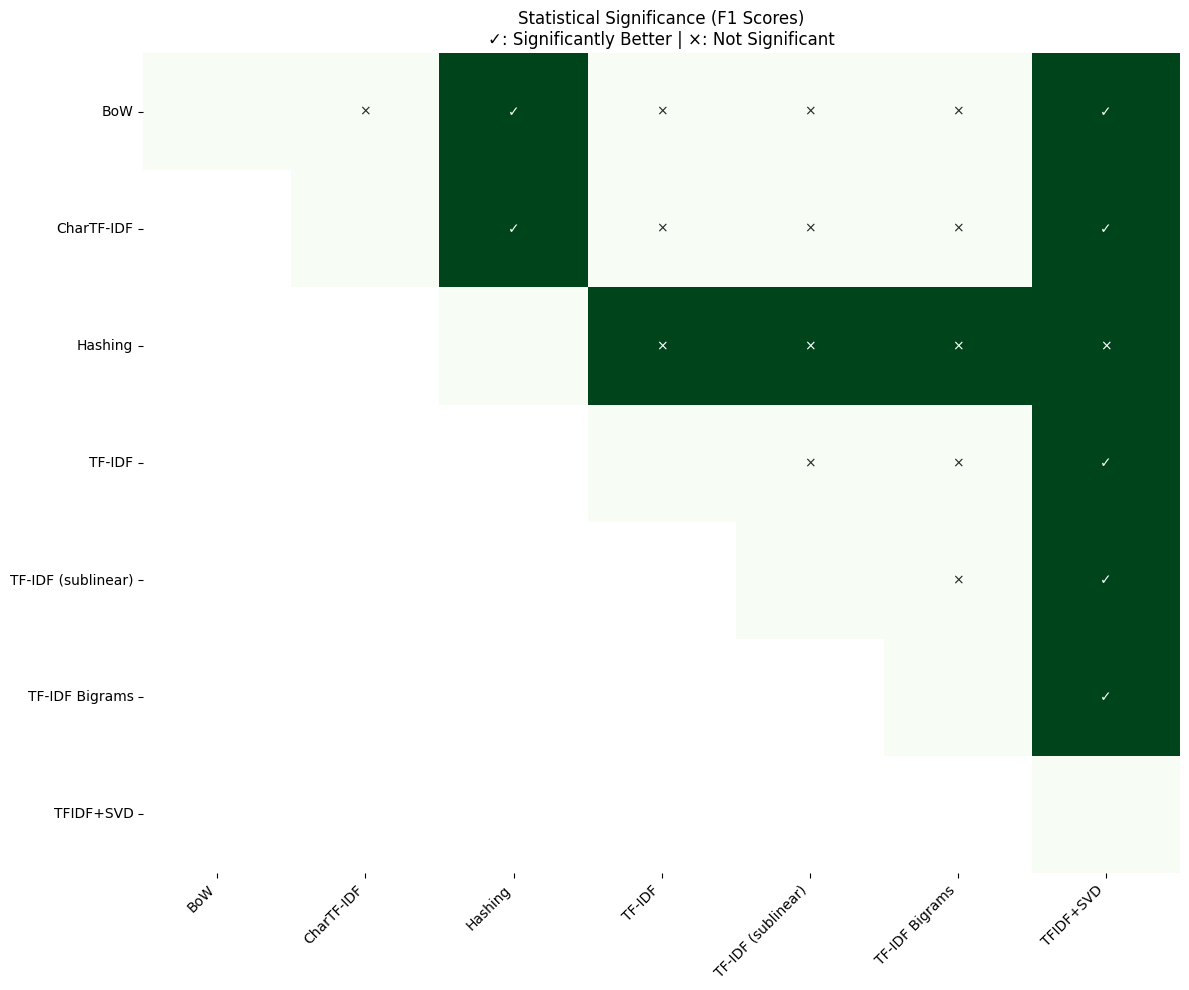

                model  cluster
0                 BoW        2
1          CharTF-IDF        2
2             Hashing        1
3              TF-IDF        2
4  TF-IDF (sublinear)        2
5      TF-IDF Bigrams        2
6           TFIDF+SVD        1


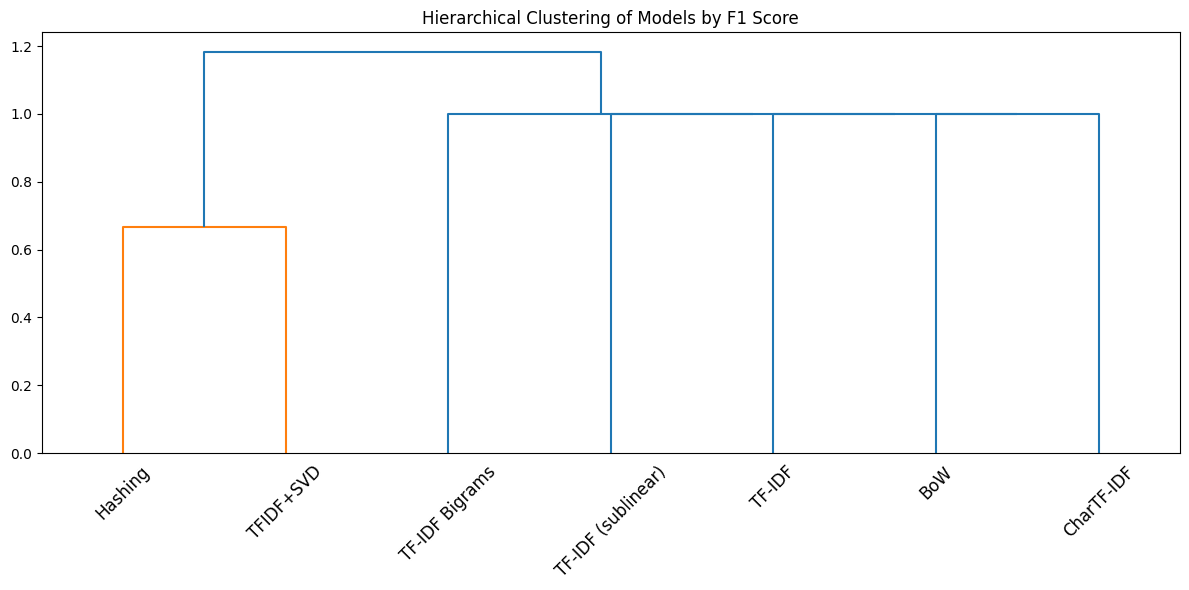

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from scipy.stats import ttest_rel
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Suppress catastrophic cancellation warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# -------------------------------
# Load your combined F1 CSV file
# -------------------------------
df_combined = pd.read_csv("results/multi_run/Structured_F1_Scores.csv")

# -------------------------------
# 1. Preprocess
# -------------------------------
df_all = df_combined.groupby(["run", "model"], as_index=False).agg({"f1": "mean"})
df_pivot = df_all.pivot(index="run", columns="model", values="f1").sort_index(axis=1)

os.makedirs("results", exist_ok=True)
df_pivot.to_csv("results/f1_score_matrix.csv")

models = df_pivot.columns.tolist()

# -------------------------------
# 2. Pairwise t-tests (Safe)
# -------------------------------
pvals = pd.DataFrame(np.ones((len(models), len(models))), index=models, columns=models)
annot = pd.DataFrame("", index=models, columns=models)

for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        if i < j:
            diff = df_pivot[m1] - df_pivot[m2]
            if np.isclose(np.var(diff), 0):
                p = 1.0  # Not significant
            else:
                _, p = ttest_rel(df_pivot[m1], df_pivot[m2])
            pvals.loc[m1, m2] = pvals.loc[m2, m1] = p
            if p < 0.05:
                better = m1 if df_pivot[m1].mean() > df_pivot[m2].mean() else m2
                annot.loc[m1, m2] = "✓" if better == m1 else "×"
                annot.loc[m2, m1] = "✓" if better == m2 else "×"
            else:
                annot.loc[m1, m2] = annot.loc[m2, m1] = "×"

pvals.to_csv("results/f1_pairwise_pvals.csv")
annot.to_csv("results/f1_pairwise_significance_matrix.csv")

# -------------------------------
# 3. Heatmaps
# -------------------------------
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(12, 10))
sns.heatmap(pvals, annot=True, fmt=".3f", cmap="coolwarm_r", mask=np.tril(pvals, -1), cbar_kws={"label": "p-value"})
plt.title("Pairwise t-test (F1 Scores) — p-values")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/pairwise_f1_pvalue_heatmap.png", dpi=300)
plt.close()

plt.figure(figsize=(12, 10))
sns.heatmap(pvals < 0.05, mask=np.tril(pvals, -1), cmap="Greens", annot=annot, fmt="", cbar=False)
plt.title("Statistical Significance (F1 Scores)\n✓: Significantly Better | ×: Not Significant")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("plots/f1_significance_matrix_annotated.png", dpi=300)
plt.show()
plt.close()

# -------------------------------
# 4. Clustering Models
# -------------------------------
corr_matrix = df_pivot.corr().fillna(0)
dist_matrix = 1 - corr_matrix
dist_matrix = (dist_matrix + dist_matrix.T) / 2
np.fill_diagonal(dist_matrix.values, 0)

link = linkage(squareform(dist_matrix.values), method="ward")
clusters = fcluster(link, t=3, criterion='maxclust')
cluster_df = pd.DataFrame({"model": models, "cluster": clusters})
cluster_df.to_csv("results/f1_model_clusters.csv", index=False)
print(cluster_df)

plt.figure(figsize=(12, 6))
dendrogram(link, labels=models, leaf_rotation=45)
plt.title("Hierarchical Clustering of Models by F1 Score")
plt.tight_layout()
plt.savefig("plots/f1_model_dendrogram.png", dpi=300)
plt.show()
plt.close()